# 목차

- Bayesian Search 알아보기
- Bayesian Search 직접 해보기

  - 직접 구현해보기
  - BayesSearchCV 사용해보기(SVM, MNIST)


---

# Bayesian Search 알아보기

Bayesian Optimization은 목적 함수의 min,혹은 max값을 찾기 위해 베이즈이론(Bayes Theorem)을 사용합니다. 이 방법은 목적 함수가 복잡하고 잡음(noise)이 많은 경우에도 유용한 방식입니다.

### 1. Objective Function(목적 함수)
Bayesian Optimization에서 목적함수란 보통 입력값 $x$에 대한 미지의 함수 $f(x)$를 의미합니다.
보통은 목적 함수의 표현식을 정확히 알지 못하기 때문에 black-box function이라고 표현하기도 합니다.

### 2. Surrogate model
현재까지 얻은 $Y=f(X)$ 를 바탕으로 미지의 목적 함수의 형태에 대한 확률적 추정을 하는 모델을 만듭니다.

### 3. Acquisition Function
목적 함수에 대한 현재까지의 추정을 기반으로 **다음 입력값 후보**를 추천하는 함수입니다.

지금까지의 정보를 기반으로 Bayesian Optimizatoin 수행 과정을 글로 표현하면 다음과 같습니다.

```
for t = 1,2,... do
    기존 (x1, f(x1)), (x2, f(x2)), ... (xt, f(xt)) 데이터셋에 대한 Surrogate model의 확률적 추정을 기반으로
    Acquisition function을 최대화하는 다음 후보 xt+1을 선정한다
    xt+1에 대한 f(xt+1)을 계산한다.
    기존 데이터셋에 (xt+1, f(xt+1))을 추가하고 Surrogate model의 확률적 추정을 다시 수행한다.
end for
```


위 글을 Pseudo code 형식으로 적으면 다음과 같습니다.
```
for t = 1,2,... do
	X, Y = [x1, ..., xt], [y1, ..., yt]
	x(t+1) = max(surrogate_model.predict, [Xsample1, Xsample2, ...])
    y(t+1) = f(x(t+1))
    X.append(x(t+1)), Y.append(y(t+1))
    surrogate_model.fit(X(t+1), y(t+1))
end for
```


# Bayesian Search 직접 해보기


### 1. Bayesian Optimization 직접 구현해보기


#### (1) 실험 셋 구현
이번에는 직접 데이터를 구성하여 실험을 진행해보도록 하겠습니다.

5개의 피크를 갖는 multimodal 함수를 가정하여 예측을 진행해보았습니다.
수식은 다음과 같습니다.

$$y = x^2 × sin(5 × PI × x)^6 + \epsilon$$

- $ϵ$: Gaussian noise

In [ ]:
from math import sin, pi
from numpy.random import normal
# objective function
def objective(x, noise=0.1):
    return (x**2 * sin(5 * pi * x)**6.0) + normal(loc=0, scale=noise)

목적 함수를 이용하여 정답과 노이즈가 있는 결과를 얻습니다.

In [ ]:
from numpy import arange
# grid-based sample of the domain [0,1]
X = arange(0, 1, 0.01)
# sample the domain without noise
y = [objective(x, 0) for x in X]
ynoise = [objective(x) for x in X]

여기서 우리는 y라는 정답을 알기에 목적 함수의 최대값 $y_{max}$과 최적점 $x_{max}$를 알고 있습니다.

In [ ]:
from numpy import argmax
# 최적점 x,y 찾기
ix = argmax(y)
print('Optima: x=%.3f, y=%.3f' % (X[ix], y[ix]))

Optima: x=0.900, y=0.810


$X$, $y$, $y_{noise}$를 plot하면 다음과 같습니다.

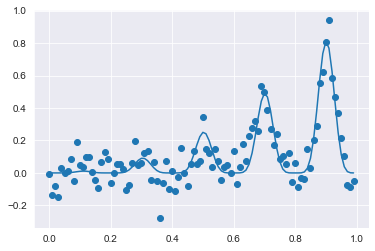

In [ ]:
from matplotlib import pyplot
# X,y(정답)곡선과 X, ynoise(노이즈) 점을 2차원 평면에 그린다.
pyplot.scatter(X, ynoise)
pyplot.plot(X, y)
pyplot.show()

다음은 목적 함수와 surrogate function을  plot하는 함수입니다.

In [ ]:
def plot(X, y, model):
	# 목적 함수를 scatter plot
	pyplot.scatter(X, y)
	# surrogate function을 sample X를 대상으로 line plot
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	pyplot.show()

### (2) Surrogate Function 구현
- 현재까지 모은 x,y 에 대해 미지의 목적함수에 대한 확률값을 추론하는 함수
- RandomForest 나 Gaussian Process 가 주로 사용되며 여기서는 scikit-learn 의 GaussianProcessRegressor 를 사용
- model은 iteration을 돌때마다 새로운 x,y에 대해 학습되며 predict 결과는 Gaussian의 mean, std로 사용

In [ ]:
def surrogate(model, X):
	return model.predict(X, return_std=True)

### (3) Acquisition Function
- 목적 함수에 대한 현재까지의 확률적 추정(surrogate)을 바탕으로 최적 입력값을 찾기 위해 가장 유용할만한 다음 입력값 후보를 찾는 함수

Acquisition Function에서 고려하는 포인트는 Exploration & Exploitation 이다. 직관적으로 설명하면 다음과 같이 표현할 수 있습니다.

- Exploration : local optima에 빠지지 않도록 Search Space를 넓게 쓴다
- Exploitation : 현재까지의 최적 입력값 후보 주위를 둘러본다

Exploration 과 Exploitation은 다음 최적 입력값 후보를 찾기 위한 서로 다른 방식으로 trade-off 관계에 있어서 상대적 강도를 적절히 조절해야 합니다.

#### **Expected Improvement (EI)**
- Exploration & Exploitation 전략 모두를 일정 수준 포함하는 알고리즘으로  Acquisition Function으로 널리 쓰임
- EI는 현재까지 추정된 목적함수를 기반으로 현재까지 조사된 f(x1), ..., f(xt) 중 최대함수값보다 더 큰 함수값을 도출할 확률(Probability of improvement, PI)를 계산
- PI와 더불어서 그 함수값과 지금까지의 최대함수값의 차이를 고려하여 해당 입력값 x의 유용성을 계산

In [ ]:
from scipy.stats import norm
# Expected Improvement(EI)의 probability of improvement(PI)를 계산하는 함수
def acquisition(X, Xsamples, model):
	# 현재 데이터셋에서 가장 큰 yhat = f(xhat)를 찾는다
	yhat, _ = surrogate(model, X)
	xhat = max(yhat)
	# surrogate 함수를 이용하여 Sample들의 mean, std를 계산한다.
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# PI를 계산한다.
	probs = norm.cdf((mu - xhat) / (std+1E-9))
	return probs

In [ ]:
from numpy.random import random
# random search로 acquisition function을 계산하여 최적값을 선택하는 함수
def opt_acquisition(X, y, model):
	# random search 방식으로 random sample을 생성한다.
	Xsamples = random(100)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# 샘플별 acquisition 함수를 통해 스코어를 계산한다.
	scores = acquisition(X, Xsamples, model)
	# 가장 높은 스코어를 뽑는다.
	ix = argmax(scores)
	return Xsamples[ix, 0]

이제 만들어둔 Surrogate, Acquisition 함수를 사용하여 목적 함수의 최적값을 찾아봅시다.
먼저 현재까지의 데이터셋 X,y, 그리고 Surrogate 함수의 Gaussian Process Regressor 모델을 데이터셋으로 학습시키는 초기화 함수 init()를 만들었습니다.

In [ ]:
def init():
	X = random(100)
	y = asarray([objective(x) for x in X])
	# reshape into rows and cols
	X = X.reshape(len(X), 1)
	y = y.reshape(len(y), 1)
	# surrogate functino에 사용할 Gaussian Process Regressor 모델
	model = GaussianProcessRegressor()
	# 지금까지 Sample로 학습한다.
	model.fit(X, y)
	return X,y, model


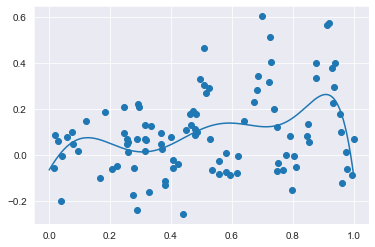

>x=0.904, f()=0.262839, actual=0.907
>x=0.905, f()=0.315028, actual=0.761
>x=0.912, f()=0.348509, actual=0.778
>x=0.783, f()=0.169616, actual=-0.062
>x=0.911, f()=0.376513, actual=0.617
>x=0.995, f()=-0.089727, actual=0.088
>x=0.934, f()=0.369071, actual=0.485
>x=0.156, f()=0.075671, actual=-0.017
>x=0.501, f()=0.120352, actual=0.220
>x=0.829, f()=0.250556, actual=0.101
>x=0.431, f()=0.079270, actual=-0.061
>x=0.194, f()=0.048010, actual=0.001
>x=0.915, f()=0.391403, actual=0.631
>x=0.187, f()=0.049199, actual=0.104
>x=0.913, f()=0.405178, actual=0.405
>x=0.914, f()=0.405249, actual=0.719
>x=0.887, f()=0.393252, actual=0.758
>x=0.845, f()=0.311886, actual=-0.052
>x=0.915, f()=0.427714, actual=0.852
>x=0.917, f()=0.447460, actual=0.584
>x=0.378, f()=0.033215, actual=0.023
>x=0.742, f()=0.094584, actual=0.292
>x=0.670, f()=0.093338, actual=0.248
>x=0.915, f()=0.451277, actual=0.593
>x=0.166, f()=0.069511, actual=-0.068
>x=0.892, f()=0.435380, actual=0.878
>x=0.638, f()=0.110312, actual=-

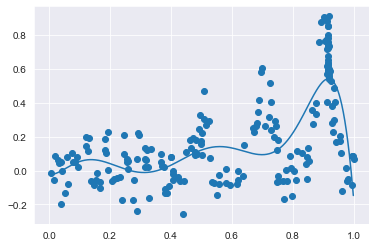

Best Result: x=0.919, y=0.909


In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from numpy import asarray, vstack

# 최적화전 데이터셋과 Surrogate model
X, y, model = init()
plot(X, y, model)
# Bayesian Optimization을 수행
for i in range(100):
	# 다음 샘플을 얻는다
	x_sample = opt_acquisition(X, y, model)
	# 목적함수를 거친 결과를 얻는다
	y_sample = objective(x_sample)
	# summarize the finding
	est, _ = surrogate(model, [[x_sample]])
	print('>x=%.3f, f()=%3f, actual=%.3f' % (x_sample, est, y_sample))
	# 새로운 x_sample, y_sample을 지금까지의 데이터셋에 추가한다
	X = vstack((X, [[x_sample]]))
	y = vstack((y, [[y_sample]]))
	# update the model
	model.fit(X, y)

# 최적화를 마친 후 결과를 그린다
plot(X, y, model)
# 최적값을 출력한다.
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

## 2. BayesSearchCV 사용해보기

Bayesian Search - Scikit-optimize 활용

이번에는 쉽게 사용할 수 있는 라이브러리를 활용하여 하이퍼파라미터를 최적화해보겠습니다. 이번엔 앞에서 직접 구현한 것과 달리 MNIST 데이터를 활용했으며, 이를 분류하기 위한 모델로 SVM 을 활용하였습니다.

- 사용모델: SVM
- 사용데이터: [MNIST](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html)

> class sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=- 1, decision_function_shape='ovr', break_ties=False, random_state=None)

- **C** : Regularization parameter, 노이즈가 많은 환경에서 C값을 줄이면 regularization을 더함
- **kernel** : kernel type, `linear`, `polynomial`, `rbf`, `sigmoid` 카테고리 중 선택
- **gamma** : rbf kernel의 파라미터로 0보다 큰 값을 가짐
- **degree** : polynomial kernel 파라미터

### 라이브러리 및 데이터 로드

In [ ]:
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X, y = load_digits(n_class=10, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=.25, random_state=0)

### 모델 최적화 및 최적화 결과

In [ ]:
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),  # integer valued parameter
        'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.9910913140311804
test score: 0.9933333333333333


수행 시 데이터 분류에 적합한 하이퍼파라미터를 찾아낸 것을 확인할 수 있습니다.

---

이번 글에서는 Bayesian Search에 대해 알아보고, 이를 코드로 구현해보았습니다. 실제 하이퍼파라미터 최적화 문제에도 적용해봤을 때, 빠르게 좋은 성능이 나오는 것을 확인해볼 수 있었습니다.


이번 글까지 HPO에서 가장 기본이 되는 알고리즘들을 살펴보았습니다. 다음 글에서는 HPO 와 관련한 논문들을 간단히 살펴보도록 하겠습니다.

읽어주셔 감사합니다. :)